# Data Source: GeoDist: The CEPII's distances and geographical database
Bilateral distances between the largest cities of those two countries (in terms
of population)

In [1]:
import pandas as pd
import pickle
import numpy as np
import sklearn

In [2]:
dis_df = pd.read_stata('dist_cepii.dta')

In [3]:
dis_df

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.093539,23.047228
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.814453,13257.814453,13168.223762,13166.366934
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913086,9516.913086,9587.315563,9584.193415
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268250,983.268250,976.897355,976.891580
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742188,9091.742188,9091.575727,9091.465815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,ZWE,YUG,0,0,0,0,0,0,0,0,7056.401855,7056.401855,7046.432349,7042.830362
50172,ZWE,ZAF,1,1,1,0,0,0,0,0,2186.205811,926.174255,1258.552190,1101.437596
50173,ZWE,ZAR,0,0,0,0,0,0,0,0,2283.061035,2283.061035,1930.976364,1719.146688
50174,ZWE,ZMB,1,1,1,0,1,0,0,0,396.804077,396.804077,583.795373,525.073446


In [4]:
with open('../pkl/global_travel_tensor_sorted.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f) 
    
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [5]:
country_cutline = 70 # 69, 70 give None homogeneity
travel_tensors = travel_tensor_raw[:,0:country_cutline,0:country_cutline]

travel_df = pd.read_csv('../csv/global_travel_df.csv')
countries = travel_df['node'].unique().T

label_dict = dict(zip(np.char.mod('%d', range(226)), countries[new_order]))
label_dict = dict(zip(range(country_cutline), countries[new_order]))

adj_list = []
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensors[4*i:4 + 4*i][:,0:country_cutline,0:country_cutline], axis=0)
    adj_list.append(ajm)
travel_tensors = np.array(adj_list)

In [6]:
travel_tensors.shape

(50, 70, 70)

In [7]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT',
 30: 'GR',
 31: 'KR',
 32: 'SA',
 33: 'CO',
 34: 'SE',
 35: 'ZA',
 36: 'TW',
 37: 'CZ',
 38: 'DK',
 39: 'CL',
 40: 'NO',
 41: 'PE',
 42: 'PL',
 43: 'NZ',
 44: 'EG',
 45: 'VN',
 46: 'QA',
 47: 'HU',
 48: 'DO',
 49: 'MA',
 50: 'IS',
 51: 'FI',
 52: 'HR',
 53: 'CR',
 54: 'BH',
 55: 'LU',
 56: 'BS',
 57: 'IL',
 58: 'UY',
 59: 'CU',
 60: 'VE',
 61: 'UA',
 62: 'JM',
 63: 'VA',
 64: 'EC',
 65: 'PA',
 66: 'CY',
 67: 'NG',
 68: 'JO',
 69: 'RS'}

In [8]:
attract = np.sum(travel_tensors, 1) # attractiveness
emit = np.sum(travel_tensors, 2) # emmisiveness
mean_adj = np.mean(travel_tensors,0)

In [9]:
avg_attract = np.mean(attract, 0)
avg_emit = np.mean(emit, 0)

In [10]:
ccode = pd.read_csv('countries_codes_and_coordinates.csv').replace('"','', regex=True).replace(' ','', regex=True)

In [11]:
label2 = list(label_dict.values())

In [12]:
label3 = []
for i in range(len(label2)):
    for j in range(len(ccode)):
        if(label2[i]==ccode.iloc[j,1]):
            if(ccode.iloc[j,2] == ccode.iloc[j-1,2]):
                continue
            label3.append(ccode.iloc[j,2])

In [13]:
gravity_df = np.zeros([country_cutline*country_cutline,4])
line = 0
for i in range(country_cutline):
    for j in range(country_cutline):
        e = avg_emit[i]
        a = avg_attract[j]
        source = label3[i]
        target = label3[j]
        y = mean_adj[i,j]
        d = dis_df[(dis_df['iso_o']==source) & (dis_df['iso_d']==target)]['dist']
        if((source==target)
           |(len(d)==0)
           |(y<1)
          ):
            e,a,d,y = -1,-1,-1,0
        gravity_df[line,0] = e
        gravity_df[line,1] = a
#         print(i,j,d)
        gravity_df[line,2] = d
        gravity_df[line,3] = y
        line += 1

In [14]:
gravity_df = pd.DataFrame(gravity_df)
gravity_df.columns = ['emit','attract','distance','T']
gravity_df = gravity_df[gravity_df['T']!=0]

In [15]:
log_grav_df = np.log(gravity_df)

In [16]:
log_grav_df['T']

1       3.355502
2       2.734368
3       2.076938
4       2.280339
5       2.225704
          ...   
4484    0.418710
4485    1.381282
4620    0.587787
4690    0.322083
4691    0.850151
Name: T, Length: 319, dtype: float64

In [17]:
log_grav_df#.to_csv('log_grav_df.csv')

,emit,attract,distance,T
1,5.610716,4.880223,8.625179,3.355502
2,5.610716,4.454580,8.672170,2.734368
3,5.610716,4.323603,8.660473,2.076938
4,5.610716,4.040944,8.838567,2.280339
5,5.610716,4.086648,8.705387,2.225704
...,...,...,...,...
4484,2.528924,4.040944,9.221985,0.418710
4485,2.528924,4.086648,9.182381,1.381282
4620,1.258461,5.495692,9.081462,0.587787
4690,2.144761,5.495692,9.047013,0.322083


# Right skewed log(T)

Text(0.5, 1.0, 'Histogram of y = log(T) ')

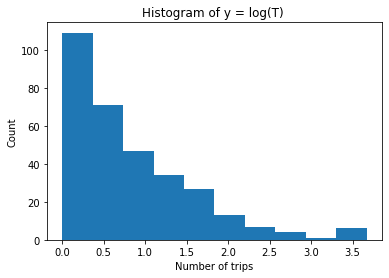

In [18]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(12,12))
# plt.scatter(log_grav_df['attract'], log_grav_df['y'])
plt.hist(log_grav_df['T'])
plt.ylabel('Count')
plt.xlabel('Number of trips')
plt.title('Histogram of y = log(T) ')

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


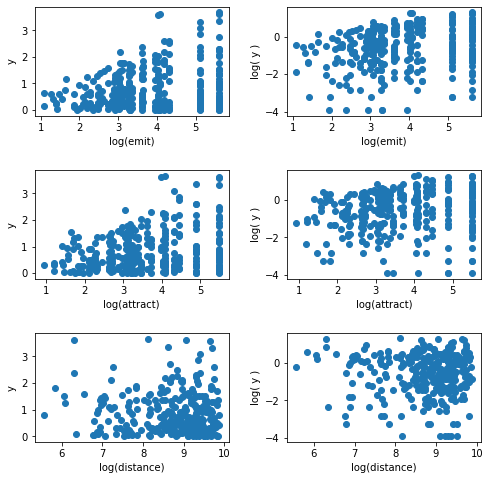

In [19]:
fig = plt.figure(figsize=[8,8])
plt.subplot(3, 2, 1)
plt.scatter(log_grav_df['emit'],(log_grav_df['T']))
plt.xlabel('log(emit)'); plt.ylabel('y')
plt.subplot(3, 2, 2)
plt.scatter(log_grav_df['emit'],np.log(log_grav_df['T']))
plt.xlabel('log(emit)'); plt.ylabel('log( y )')

plt.subplot(3, 2, 3)
plt.scatter(log_grav_df['attract'],(log_grav_df['T']))
plt.xlabel('log(attract)'); plt.ylabel('y')
plt.subplot(3, 2, 4)
plt.scatter(log_grav_df['attract'],np.log(log_grav_df['T']))
plt.xlabel('log(attract)'); plt.ylabel('log( y )')

plt.subplot(3, 2, 5)
plt.scatter(log_grav_df['distance'],(log_grav_df['T']))
plt.xlabel('log(distance)'); plt.ylabel('y')
plt.subplot(3, 2, 6)
plt.scatter(log_grav_df['distance'],np.log(log_grav_df['T']))
plt.xlabel('log(distance)'); plt.ylabel('log( y )')

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [20]:
# plt.hist(np.log(log_grav_df_processed['T']), bins =30)

In [21]:
import statsmodels.api as sm
log_grav_df_processed = log_grav_df[log_grav_df['T']>0]
X = (log_grav_df_processed[['emit','attract','distance']])
y = (log_grav_df_processed['T'])

glm = sm.GLM(y, X, family=sm.families.Gaussian(link=sm.families.links.log))
# glm = sm.GLM(y, X, family=sm.families.Tweedie(link=sm.families.links.log, var_power=0.1))
result = glm.fit()
result.summary()
# gamma_model = smf.glm(formula='y ~ emit + attract + distance', data=log_grav_df, family=sm.families.Gaussian(sm.families.links.identity))
# gamma_results = gamma_model.fit()
# print(gamma_results.summary())

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      T   No. Observations:                  310
Model:                            GLM   Df Residuals:                      307
Model Family:                Gaussian   Df Model:                            2
Link Function:                    log   Scale:                         0.40546
Method:                          IRLS   Log-Likelihood:                -298.45
Date:                Sun, 14 Jun 2020   Deviance:                       124.48
Time:                        10:28:35   Pearson chi2:                     124.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
emit           0.3289      0.032     10.204      0.000       0.266       0.392
attract        0.2999      0.031      9.662      0.000       0.239       0.361
distance      -0.2949      0.025    -11.954      0.000      -0.343      -0.247
==============================================================================
"""

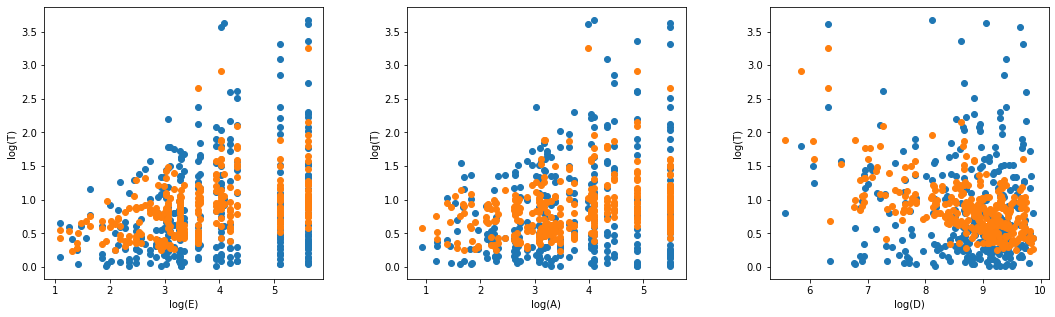

In [22]:
pred = result.predict(log_grav_df_processed[['emit','attract','distance']])

fig = plt.figure(figsize=[18,5])
plt.subplot(1, 3, 1)
X= log_grav_df_processed['emit']
plt.scatter(X,log_grav_df_processed['T'])
plt.scatter(X,pred)
plt.xlabel("log(E)")
plt.ylabel("log(T)")

plt.subplot(1, 3, 2)
X= log_grav_df_processed['attract']
plt.scatter(X,log_grav_df_processed['T'])
plt.scatter(X,pred)
plt.xlabel("log(A)")
plt.ylabel("log(T)")

plt.subplot(1, 3, 3)
X= log_grav_df_processed['distance']
plt.scatter(X,log_grav_df_processed['T'])
plt.scatter(X,pred)
plt.xlabel("log(D)")
plt.ylabel("log(T)")

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [23]:
import statsmodels.api as sm

X = (log_grav_df_processed[['emit','attract','distance']])
y = (log_grav_df_processed['T'])

# Note the difference in argument order
model = sm.OLS((y), X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      T   R-squared (uncentered):                   0.675
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              212.5
Date:                Sun, 14 Jun 2020   Prob (F-statistic):                    1.39e-74
Time:                        10:28:36   Log-Likelihood:                         -305.56
No. Observations:                 310   AIC:                                      617.1
Df Residuals:                     307   BIC:                                      628.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
emit           0.2774      0.032      8.690      0.000       0.215       0.340
attract        0.2659      0.032      8.368      0.000       0.203       0.328
distance      -0.1316      0.022     -5.939      0.000      -0.175      -0.088
==============================================================================
Omnibus:                       28.747   Durbin-Watson:                   1.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.904
Skew:                           0.775   Prob(JB):                     4.34e-08
Kurtosis:                       3.475   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')
xaxis = week_slices[0::4]

In [25]:
cnt1=24
cnt2=0
time = -18
RU_emit = np.sum(travel_tensors[time,:], 1)[cnt1]
US_emit = np.sum(travel_tensors[time,:], 1)[cnt2]
RU_attract = np.sum(travel_tensors[time,:], 0)[cnt1]
US_attract = np.sum(travel_tensors[time,:], 0)[cnt2]
d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
d = np.float(d)

In [26]:
# pred_RU_to_US = result.predict(np.log([RU_emit, US_attract, d]))
# pred_US_to_RU = result.predict(np.log(np.array([US_emit, RU_attract, d])+1e-30))
pred_US_to_RU_list = []
pred_RU_to_US_list = []
for t in range(24):
    RU_emit = np.sum(travel_tensors[-24+t,:], 1)[cnt1]
    US_emit = np.sum(travel_tensors[-24+t,:], 1)[cnt2]
    RU_attract = np.sum(travel_tensors[-24+t,:], 0)[cnt1]
    US_attract = np.sum(travel_tensors[-24+t,:], 0)[cnt2]
    d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
    d = np.float(d)
    pred_US_to_RU = result.predict(np.log(np.array([US_emit, RU_attract, d])+1e-30))
    pred_US_to_RU_list.append(pred_US_to_RU)
    pred_RU_to_US = result.predict(np.log(np.array([RU_emit, US_attract, d])+1e-30))
    pred_RU_to_US_list.append(pred_RU_to_US)

In [35]:
print(xaxis[-19])
print(xaxis[-18])

2018-06-24 00:00:00
2018-07-22 00:00:00


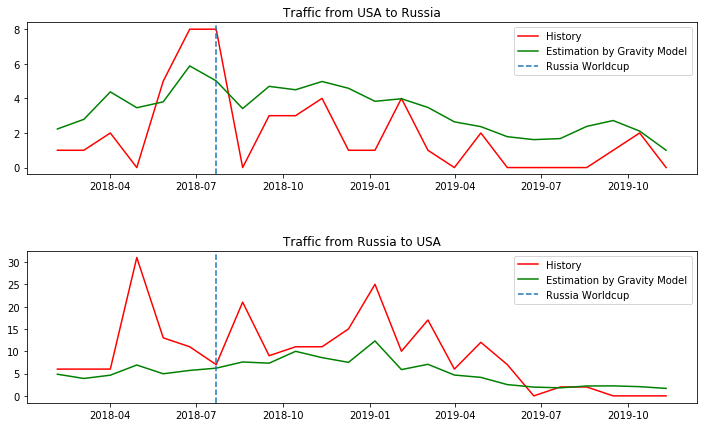

In [28]:
# y = travel_tensors[-24:,cnt2,cnt1] - np.exp(pred_US_to_RU_list).T
# y = y[0]
fig = plt.figure(figsize=[12,7])
plt.subplot(2, 1, 1)
plt.plot(xaxis[-24:],travel_tensors[-24:,cnt2,cnt1], color='red', label='History')
plt.plot(xaxis[-24:],np.exp(pred_US_to_RU_list), color='green', label='Estimation by Gravity Model')
plt.axvline(xaxis[time], linestyle='--', label='Russia Worldcup')
plt.title('Traffic from USA to Russia')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(xaxis[-24:],travel_tensors[-24:,cnt1,cnt2], color='red', label='History')
plt.plot(xaxis[-24:],np.exp(pred_RU_to_US_list), color='green', label='Estimation by Gravity Model')
plt.axvline(xaxis[time], linestyle='--', label='Russia Worldcup')
plt.title('Traffic from Russia to USA')
plt.legend()

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [29]:
# cnt1=24
# cnt2=0
# time = -18
RU_emit = np.sum(travel_tensors[time,:], 1)[cnt1]
US_emit = np.sum(travel_tensors[time,:], 1)[cnt2]
RU_attract = np.sum(travel_tensors[time,:], 0)[cnt1]
US_attract = np.sum(travel_tensors[time,:], 0)[cnt2]
d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
d = np.float(d)

In [30]:
logT_RUtoUS = np.log(travel_tensors[time,cnt1,cnt2])
logT_UStoRU = np.log(travel_tensors[time,cnt2,cnt1])

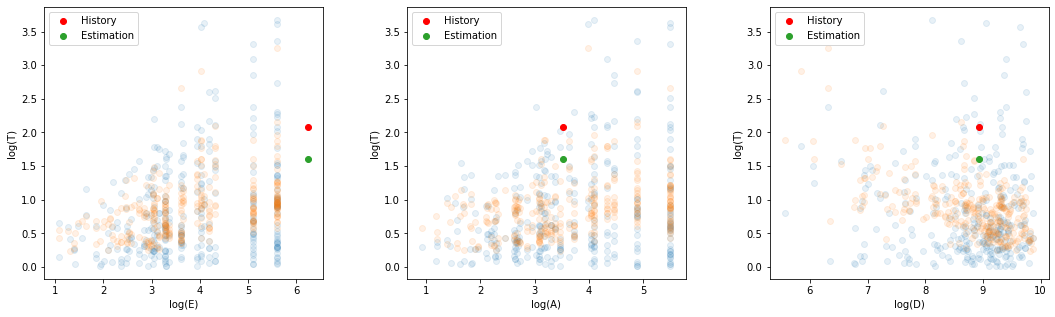

In [31]:
pred = result.predict(log_grav_df_processed[['emit','attract','distance']])
pred_RU_to_US = result.predict(np.log([RU_emit, US_attract, d]))
pred_US_to_RU = result.predict(np.log([US_emit, RU_attract, d]))

fig = plt.figure(figsize=[18,5])
plt.subplot(1, 3, 1)
X= log_grav_df_processed['emit']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(US_emit), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(US_emit), pred_US_to_RU, label = 'Estimation')
plt.xlabel("log(E)")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 2)
X= log_grav_df_processed['attract']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(RU_attract), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(RU_attract), pred_US_to_RU, label = 'Estimation')
plt.xlabel("log(A)")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 3)
X= log_grav_df_processed['distance']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(d), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(d), pred_US_to_RU, label = 'Estimation')

plt.xlabel("log(D)")
plt.ylabel("log(T)")
plt.legend()

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

(array([35., 37., 29., 28., 28., 16., 14., 17., 15., 10., 13., 11., 12.,
         6.,  9.,  2.,  6.,  4.,  4.,  2.,  1.,  2.,  1.,  1.,  0.,  1.,
         0.,  2.,  0.,  4.]),
 array([0.01980263, 0.14146576, 0.26312889, 0.38479203, 0.50645516,
        0.6281183 , 0.74978143, 0.87144456, 0.9931077 , 1.11477083,
        1.23643396, 1.3580971 , 1.47976023, 1.60142336, 1.7230865 ,
        1.84474963, 1.96641276, 2.0880759 , 2.20973903, 2.33140217,
        2.4530653 , 2.57472843, 2.69639157, 2.8180547 , 2.93971783,
        3.06138097, 3.1830441 , 3.30470723, 3.42637037, 3.5480335 ,
        3.66969663]),
 <a list of 30 Patch objects>)

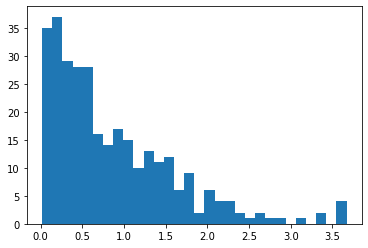

In [32]:
plt.hist(log_grav_df_processed['T'], bins=30)

In [33]:
# 100 0.770
# 80, 0.738
# 70, 0.727
# cutline = 60, R2 = 0.701
# cutline = 50, R2 = 0.66
# cutline = 40, R2 = 0.62


In [34]:
# Mean >= 1 filter
# 100, 0.656
# 70, 0.660